In [ ]:
import random
from functools import partial
import matplotlib
import matplotlib.image as mpimg
import sys
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import Dataset
import os
from google.colab import drive
!pip install segmentation_models_pytorch
drive.mount('/content/gdrive')
import seaborn as sns
import segmentation_models_pytorch as smp
from segmentation_models_pytorch import Unet, UnetPlusPlus, DeepLabV3
import segmentation_models_pytorch
!pip install torchmetrics
from torchmetrics.functional import f1_score
from torch.optim.lr_scheduler import ReduceLROnPlateau

In [38]:
###
###
# Paths
root_dir = "/content/gdrive/MyDrive/ML/data/augmented4/"
image_dir = root_dir + "images/"
gt_dir = root_dir + "groundtruth"
test_image_dir = "data/test_set_images_gradient/"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [36]:
# Hyper parameters
PADDING = 0
EPOCH = 45
BATCH_SIZE = 10
NR_IMAGES = 30
IMAGE_SIZE = 256

In [37]:
class PreloadedDataset(Dataset):
    def __init__(self, images, ground_truth):
        self.images = images
        self.ground_truth = ground_truth

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        ground_truth = self.ground_truth[idx]
        return image, ground_truth


def split(dataset, tr,val):
    train_dataset, val_dataset = torch.utils.data.random_split(dataset, [tr, val])
    return train_dataset, val_dataset

def get_dataloaders(train_dataset, val_dataset, batch_size):
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
    return train_loader, val_loader

def load_npy(npy_file_path):
  array = np.load(npy_file_path)
  return array

def load_image(infilename):
    data = mpimg.imread(infilename)
    return data

def get_image_name(image_dir):
    file_name = os.path.basename(image_dir)
    return file_name

def img_crop(im, w, h):
    list_patches = []
    imgwidth = im.shape[0]
    imgheight = im.shape[1]

    is_2d = len(im.shape) < 3
    for i in range(0, imgheight, h):
        for j in range(0, imgwidth, w):
            if is_2d:
                im_patch = im[j : j + w, i : i + h]
            else:
                im_patch = im[j : j + w, i : i + h, :]
            list_patches.append(im_patch)
    return list_patches

def predict_patches(prediction, patch_threshold):
    patches = img_crop(prediction, 16, 16)
    iter = int(np.sqrt(len(patches)))
    results = np.zeros((iter, iter))
    c = 0
    for j in range(iter):
      for i in range(iter):
        if patches[c].mean() > patch_threshold:
          results[i, j] = 1
        c = c + 1
    return results

def masks_to_submission(submission_filename, results):
    """Converts images into a submission file"""
    img_number = 0
    with open(submission_filename, 'w') as f:
        f.write('id,prediction\n')
        for res in results:
            img_number = img_number + 1
            f.writelines('{}\n'.format(s) for s in mask_to_submission_strings(res, img_number))

def mask_to_submission_strings(result, img_number):
    """Reads a single image and outputs the strings that should go into the submission file"""
    im = result
    patch_size = 16
    for j in range(0, im.shape[1]):
        for i in range(0, im.shape[0]):
            label = result[i, j]

            yield("{:03d}_{}_{},{}".format(img_number, j*16, i*16, int(label)))

def write_predictions_to_file(predictions, labels, filename):
    max_labels = np.argmax(labels, 1)
    max_predictions = np.argmax(predictions, 1)
    file = open(filename, "w")
    n = predictions.shape[0]
    for i in range(0, n):
        file.write(max_labels(i) + " " + max_predictions(i))
    file.close()

def compute_f1(res, ans):
    """
    Precision: tp/(tp+fp)
    Recall: tp/(tp+fn)
    F1 = 2 * (precision * recall) / (precision + recall)
    """

    tp = torch.sum((res == 1) & (ans == 1))
    fp = torch.sum((res == 1) & (ans != 1))
    fn = torch.sum((res != 1) & (ans == 1))

    precision = tp / (tp + fp) if (tp + fp) != 0 else torch.tensor(0.0)
    recall = tp / (tp + fn) if (tp + fn) != 0 else torch.tensor(0.0)
    if precision + recall == 0:
        return torch.tensor(0.0)
    else:
        return 2 * (precision * recall) / (precision + recall)


def get_threshold(predictions,labels):
    f1_max = 0
    th = 0

    for t in range(0,100):
        t = t/100
        th_pred = predictions.clone()
        patches = predict_patches(th_pred, t)
        f1 = f1_score(torch.tensor(patches), torch.tensor(labels), task='binary')

        if f1>f1_max:
            f1_max = f1
            th = t
    return th

def train_epoch(model, optimizer, scheduler, criterion, train_loader, epoch, device):
    model.train()

    # Use tensors for histories
    total_loss = torch.tensor(0.0, device=device)
    total_samples = 0
    total_accuracy = torch.tensor(0.0, device=device)
    total_f1 = torch.tensor(0.0, device=device)
    batch_iter = 0
    for batch_idx, (batch_data, batch_labels) in enumerate(train_loader):

        # Prepare batch
        batch_data = batch_data.to(device)
        batch_labels = batch_labels.to(device)


        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        output = model(batch_data)

        # Compute loss
        loss = criterion(output, batch_labels)
        total_loss = total_loss + loss

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Compute accuracy and F1 per batch
        predictions = (output > 0.3).int()  # Hardcoded threshold
        batch_correct = (predictions == batch_labels).sum()

        batch_accuracy = batch_correct / (batch_labels.shape[0] * batch_labels.shape[1] * batch_labels.shape[2] * batch_labels.shape[3])
        total_accuracy = total_accuracy + batch_accuracy

        total_f1 = total_f1 + f1_score(predictions, batch_labels, task='binary')



        batch_iter = batch_iter + 1




    # Compute averages for the epoch
    epoch_loss = total_loss / batch_iter
    epoch_accuracy = total_accuracy / batch_iter
    epoch_f1 = total_f1 / batch_iter

    # Log the learning rate history
    lr_value = scheduler.get_last_lr()[0]

    print(
        f"Epoch Summary: {epoch} "
        f"Epoch Loss={epoch_loss.item():.3e} "
        f"Accuracy={epoch_accuracy.item():.3f} "
        f"F1={epoch_f1.item():.3e} "
        f"LR={lr_value:.3e}"
    )

    # Return metrics as tensors
    return epoch_loss, epoch_accuracy, lr_value, epoch_f1


@torch.no_grad()
def validate(model, device, val_loader, criterion):
    model.eval()  # Important: eval mode (affects dropout, batch norm, etc.)

    # Initialize tensors for aggregating metrics
    total_loss = torch.tensor(0.0, device=device)
    total_accuracy = torch.tensor(0.0, device=device)
    total_f1 = torch.tensor(0.0, device=device)


    batch_iter = 0
    for data, target in val_loader:
        # Prepare batch

        data = data.to(device)
        target = target.to(device)

        # Forward pass
        output = model(data)



        # Compute loss
        batch_loss = criterion(output, target)
        total_loss = total_loss +  batch_loss

        # Compute predictions
        probabilities = F.sigmoid(output)
        predictions = (probabilities > 0.3).int()  # Hardcoded threshold
        total_f1 = total_f1 + compute_f1(predictions, target)

        # F1 and accuracy
        batch_correct = (predictions == target).sum()
        batch_accuracy = batch_correct / (target.shape[0] * target.shape[1] * target.shape[2] * target.shape[3])

        total_accuracy = total_accuracy + batch_accuracy




        batch_iter = batch_iter + 1

    # Compute averages
    avg_loss = total_loss / batch_iter
    avg_accuracy = total_accuracy / batch_iter
    avg_f1 = total_f1 / batch_iter

    # Print validation summary
    print(
        f"Validation Set: Average Loss: {avg_loss.item():.4f}, "
        f"Accuracy: {avg_accuracy.item() * 100:.2f}%, "
        f"F1: {avg_f1.item():.4f}, "
    )

    # Return metrics as tensors
    return avg_loss, avg_f1, avg_accuracy * 100


def run_training(
    model,
    num_epochs,
    optimizer_kwargs,
    data_kwargs,
    device="cuda",

):
    # ===== Data Loading =====
    train_loader, val_loader = get_dataloaders(**data_kwargs)

    # ===== Model, Optimizer and Criterion =====
    model = model.to(device=device)
    # model.apply(init_weights)
    #optimizer = torch.optim.AdamW(model.parameters(), **optimizer_kwargs)
    optimizer = torch.optim.SGD(model.parameters(), **optimizer_kwargs)
    # criterion = DiceLoss()
    criterion = segmentation_models_pytorch.losses.DiceLoss("binary")
    # scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.90)
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)


    # ===== Train Model =====
    lr_history = []
    train_loss_history = []
    train_acc_history = []
    val_loss_history = []
    val_acc_history = []
    val_f1_history = []
    train_f1_history = []
    for epoch in range(1, num_epochs + 1):
        print(f'Epoch {epoch}/{num_epochs}')
        train_loss, train_acc, lrs, f1_hist = train_epoch(
            model, optimizer, scheduler, criterion, train_loader, epoch, device
        )
        train_loss_history.append(train_loss)
        train_acc_history.append(train_acc)
        lr_history.append(lrs)

        val_loss, f1, val_acc = validate(model, device, val_loader, criterion)
        val_loss_history.append(val_loss)
        val_f1_history.append(f1)
        val_acc_history.append(val_acc)
        train_f1_history.append(f1_hist)
        scheduler.step(train_loss)

    return train_loss_history, train_acc_history, val_loss_history, val_f1_history, val_acc_history, train_f1_history


In [23]:
###
###
# Loading data set


imgs = []
gt_imgs = []
image_files = sorted(os.listdir(image_dir))[:NR_IMAGES]
gt_files = sorted(os.listdir(gt_dir))[:NR_IMAGES]
org_len = len(gt_files)
img_nr = 0

for image_file in image_files:
    # Removing from image name (extended)
    image_name = os.path.splitext(image_file)[0]#[:-10]
    matching_gt_file = None

    gt_match_index = 0
    for gt_file in gt_files:

        gt_name = os.path.splitext(gt_file)[0]

        if gt_name[-4:] == '.png':
            gt_name = gt_name[:-4]
        if gt_name == image_name:
            matching_gt_file = gt_file
            img_nr = img_nr + 1
            print(f'{img_nr} / {org_len} loaded')
            break

    if matching_gt_file:
        image_path = os.path.join(image_dir, image_file)
        gt_path = os.path.join(gt_dir, matching_gt_file)

        image = load_image(image_path)
        gt_image = load_image(gt_path)
        imgs.append(image)
        # imgs.append(image[144:, :256,:])
        # imgs.append(image[:256, 144:,:])
        # imgs.append(image[144:, 144:,:])

        gt_imgs.append(gt_image)
        # gt_imgs.append(gt_image[144:, :256])
        # gt_imgs.append(gt_image[:256, 144:])
        # gt_imgs.append(gt_image[144:, 144:])


1 / 30 loaded
2 / 30 loaded
3 / 30 loaded
4 / 30 loaded
5 / 30 loaded
6 / 30 loaded
7 / 30 loaded
8 / 30 loaded
9 / 30 loaded
10 / 30 loaded
11 / 30 loaded
12 / 30 loaded
13 / 30 loaded
14 / 30 loaded
15 / 30 loaded
16 / 30 loaded
17 / 30 loaded
18 / 30 loaded
19 / 30 loaded
20 / 30 loaded
21 / 30 loaded
22 / 30 loaded
23 / 30 loaded
24 / 30 loaded
25 / 30 loaded
26 / 30 loaded
27 / 30 loaded
28 / 30 loaded
29 / 30 loaded
30 / 30 loaded


In [29]:
# Converting to float
imgs = np.array([sub_arr.astype(np.float32) for sub_arr in imgs])
gt_imgs = np.array([sub_arr.astype(np.float32) for sub_arr in gt_imgs])

# Making sure gt is binary, road or no road
gt_imgs[gt_imgs > 0] = 1

AttributeError: 'Tensor' object has no attribute 'astype'

In [28]:
# Converting to tensors
gt_imgs = torch.tensor(gt_imgs)
imgs = torch.tensor(imgs)

<ipython-input-28-949330e1b972>:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gt_imgs = torch.tensor(gt_imgs)
<ipython-input-28-949330e1b972>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  imgs = torch.tensor(imgs)


In [26]:
imgs.shape
imgs = imgs.permute(0, 3, 1, 2)

In [27]:
gt_imgs = gt_imgs.reshape(gt_imgs.shape[0], 1, 256, 256)
gt_imgs.shape

RuntimeError: shape '[30, 1, 256, 256]' is invalid for input of size 4800000

In [32]:
!unzip /content/gdrive/MyDrive/ML/data/augmented4.zip -d /content/gdrive/MyDrive/ML/data/

Utdata för streaming har trunkerats till de sista 5000 raderna.
  inflating: /content/gdrive/MyDrive/ML/data/augmented4/images/satImage_011_zoomed.png  
  inflating: /content/gdrive/MyDrive/ML/data/__MACOSX/augmented4/images/._satImage_011_zoomed.png  
  inflating: /content/gdrive/MyDrive/ML/data/augmented4/images/satImage_059_jittered2.png  
  inflating: /content/gdrive/MyDrive/ML/data/__MACOSX/augmented4/images/._satImage_059_jittered2.png  
  inflating: /content/gdrive/MyDrive/ML/data/augmented4/images/satImage_057_rotated85.png  
  inflating: /content/gdrive/MyDrive/ML/data/__MACOSX/augmented4/images/._satImage_057_rotated85.png  
  inflating: /content/gdrive/MyDrive/ML/data/augmented4/images/satImage_042_rotated65.png  
  inflating: /content/gdrive/MyDrive/ML/data/__MACOSX/augmented4/images/._satImage_042_rotated65.png  
  inflating: /content/gdrive/MyDrive/ML/data/augmented4/images/satImage_064_jittered3.png  
  inflating: /content/gdrive/MyDrive/ML/data/__MACOSX/augmented4/image

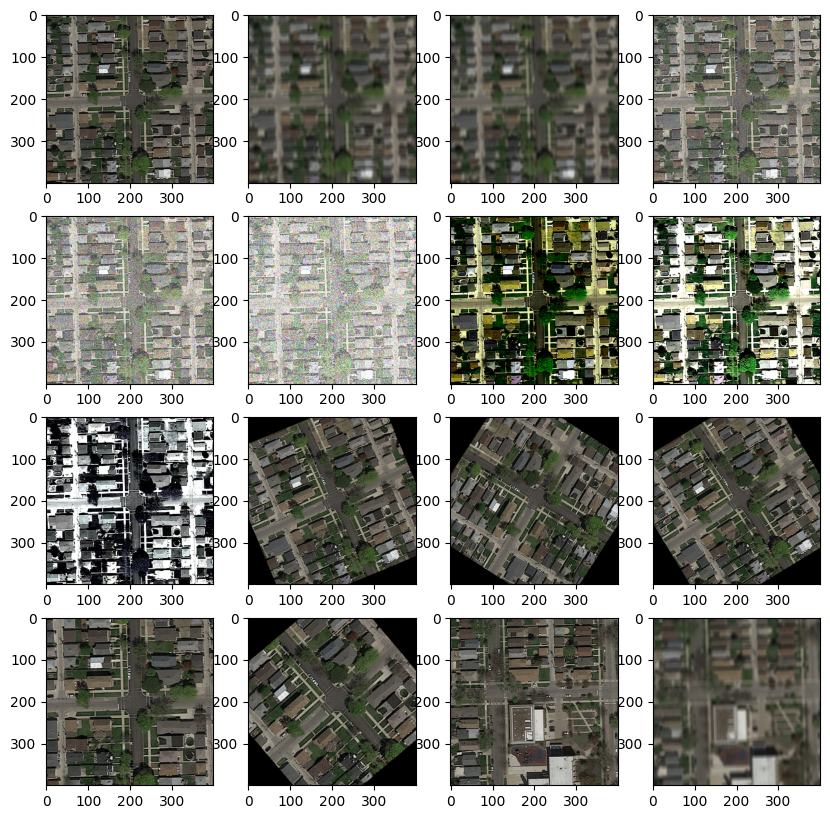

In [31]:
fig, axs = plt.subplots(4, 4, figsize=(10, 10))
for i in range(16):
  axs[i // 4, i % 4].imshow(imgs[i].permute(1, 2, 0).numpy())


